In [7]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt

In [8]:
TFtot = 2000
kon = 0.0016399 
koff_invert = 0.34393
koff_amp = 0.34393 / 2
kbasal_invert = 0.02612 
kbasal_amp = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p_amp =  kon, TFtot, koff_amp, kbasal_amp, kmax, n, Kd, kdegR, ktrans, kdegP
p_invert = kon, TFtot, koff_invert, kbasal_invert, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled_amp = kmax * kdegR / (kbasal_amp + kmax)
kbasal_scaled_amp = kbasal_amp * kdegR / (kbasal_amp + kmax)
k_alpha_amp = kon * 1000 / koff_amp
k_beta_amp = koff_amp 

p_scaled_amp = k_alpha_amp, k_beta_amp, kbasal_scaled_amp, kmax_scaled_amp, n, Kd_scaled, kdegR


Kd_scaled = Kd / TFtot
kmax_scaled_invert = kmax * kdegR / (kbasal_invert + kmax)
kbasal_scaled_invert = kbasal_invert * kdegR / (kbasal_invert + kmax)
k_alpha_invert = kon * 1000 / koff_invert
k_beta_invert = koff_invert

p_scaled_invert = k_alpha_invert, k_beta_invert, kbasal_scaled_invert, kmax_scaled_invert, n, Kd_scaled, kdegR


In [19]:
def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step, p_scaled):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, p_scaled, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol


    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step, p_scaled), tol=1e-9)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step, p_scaled), tol=1e-9)

    steady = np.maximum(sol.x,[0,0])
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    steady = np.trapz(sol.y, x=sol.t) / period

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p, control_p, u0, mRNA_funs, ratio_sp=None, od_sp=None):

    # Parameters
    kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp = p

    K_P, K_I, K_D = control_p
    mRNA_inv_fun, mRNA_amp_fun = mRNA_funs

    x_guess = x
    global setpoint_amp, setpoint_invert
    # if setpoint is None:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess)
    # else:
    #     out = setpoint
    # if ier != 1:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess=None)

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp, I = x
    # mRNA_blind = 1

    mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S)
    mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S)

    S0 = 20
    if od_sp is None:
        d = 0
    else:
        d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)
        if (X_invert + X_amp) < od_sp:
            d = 0
        elif (X_invert + X_amp) > od_sp:
            d = d #* (X_invert + X_amp)/od_sp

    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp + d * (S0 - S)
    dX_invert_dt = mu_x_invert * X_invert - d * X_invert
    dX_amp_dt = mu_x_amp * X_amp - d * X_amp

    X1X2_ratio = X_invert / X_amp
    dX1X2_ratio = (1/X_amp) * dX_invert_dt - (X_invert/X_amp**2) * dX_amp_dt

    if ratio_sp is None:
        u = u0
        dIdt = 0
    else:
        if callable(ratio_sp):
            target = ratio_sp(t)
        u = u0 + K_P * (X1X2_ratio - target) + K_I * I + K_D * dX1X2_ratio
        u = np.clip(u, -5, 0)
        u = 10 ** u
        dIdt = (X1X2_ratio - target)

    dmRNA_invert_dt = (mRNA_inv_fun(u) - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (mRNA_amp_fun(u) - mRNA_amp) / tau_mRNA

    # Enz_opto = Enz_opto / ((mu_max_opto + kdegP) / ktrans)
    ktrans_scaled_invert = ktrans  * ((mu_max_invert + kdegP) / ktrans)
    ktrans_scaled_PDC_invert = ktrans  * ((mu_max_invert + kdegPPDC) / ktrans)
    
    dRepdt = ktrans_scaled_invert * mRNA_invert * S / (Ks + S) - (kdegP + mu_x_invert) * Rep
    dEnz_invert_dt = ktrans_scaled_PDC_invert * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert
    # dEnz_optodt = dEnz_optodt * ((mu_max_opto + kdegP) / ktrans)

    # Enz_blind = Enz_blind / ((mu_max_blind + kdegP) / ktrans)
    ktrans_scaled_amp = ktrans  * ((mu_max_amp + kdegP) / ktrans)
    ktrans_scaled_PDC_amp = ktrans  * ((mu_max_amp + kdegPPDC) / ktrans)
    
    dAmpdt = ktrans_scaled_amp * mRNA_amp * S / (Ks + S) - (kdegP + mu_x_amp) * Amp
    dEnz_amp_optodt = ktrans_scaled_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp
    # dEnz_blind_optodt = dEnz_blind_optodt * ((mu_max_blind + kdegP) / ktrans)


    S0 = 20
    if od_sp is None:
        d = 0
    else:
        d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)
        if (X_invert + X_amp) < od_sp:
            d = 0
        elif (X_invert + X_amp) > od_sp:
            d = d #* (X_invert + X_amp)/od_sp
    
    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp + d * (S0 - S)
    dX_invert_dt = mu_x_invert * X_invert - d * X_invert
    dX_amp_dt = mu_x_amp * X_amp - d * X_amp




    return [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt, dIdt]


In [10]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.00
K_Rep = 0.01
K_Amp = 0.99

mu_max_invert = 0.0233 / 20
mu_max_amp = 0.014 / 20

# mu_max = mu_max_opto
Ks = 1
Y = 0.5

In [11]:
from tqdm import tqdm

if False:

    u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,100))))

    # u_arr = np.flip(10 ** np.linspace(-1,0,100))
    Enz_arr = np.zeros(u_arr.size)
    mRNA_arr_amp = np.zeros(u_arr.size)
    mRNA_arr_invert = np.zeros(u_arr.size)

    setpoint_amp = None
    setpoint_invert = None

    for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
        # print(u)
        period = 100 / 60
        Imax = 1
        setpoint_amp = steady_mRNA_solve(u, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
        # print(setpoint)
        mRNAss = setpoint_amp[1]
        mRNA_arr_amp[i] = mRNAss

        setpoint_invert = steady_mRNA_solve(u, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

        mRNAss = setpoint_invert[1]
        mRNA_arr_invert[i] = mRNAss


100%|██████████| 101/101 [08:06<00:00,  4.82s/it]


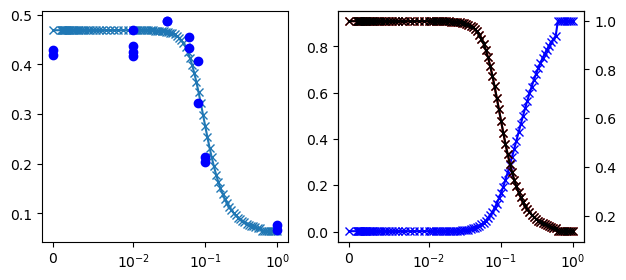

In [13]:
from scipy.optimize import fsolve

# Inverted Circuit
# 
# u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

kdegR = 0.042116
ktrans = 1.4514
kdegP = np.log(2) / (6 * 60)
kdegPPDC = np.log(2) / (12 * 60)
K_Rep = 0.2
n_Rep = 1.3
mu_max_invert = 0.47 / 60

K_Amp = 0.2
mu_max_amp = 0.5 / 60
n_Amp = 1.0

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp


od_sp = 0.01

S = 20 - 2 / Y

steady_state_arr_invert = np.zeros((u_arr.size, 9))
steady_state_arr_amp = np.zeros((u_arr.size, 9))

x_init = [mRNA_arr_amp[0], mRNA_arr_amp[0], mRNA_arr_amp[0], mRNA_arr_amp[0], mRNA_arr_amp[0], mRNA_arr_amp[0], 20, 0, 0.0]
x_init_inv = [mRNA_arr_invert[0], mRNA_arr_invert[0], mRNA_arr_invert[0], mRNA_arr_invert[0], mRNA_arr_invert[0], mRNA_arr_invert[0], 20, 0, 0.0]

for index, u in tqdm(enumerate(u_arr), total=u_arr.size):
    # print(u)
    # period = 100 / 60
    # Imax = 1
    # setpoint = steady_mRNA_solve(u, period, Imax, x_guess=setpoint)
    # # print(setpoint)
    # mRNAss = setpoint[1]
    # mRNA_arr[i] = mRNAss

    setpoint_invert = np.array([0, mRNA_arr_invert[index]])
    setpoint_amp = np.array([0, mRNA_arr_amp[index]])
    # mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x


    x_init_inv[-2] = 0.1
    x_init_inv[-1] = 0.
    tspan = np.array([0, 500*60])
    optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, 0, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init_inv, args=(optogrowth_p,od_sp),
                        rtol=1e-6, atol=1e-9, 
                        method='BDF',
                        first_step = 0.0001,
                        )
#     print('solveIvp', sol.message)
    x_init_inv = sol.y[:,-1]

    # plt.figure()
    # for i in range(9):
    #     plt.plot(sol.t, sol.y[i,:]/max(sol.y[i,:]), label=i)
    # plt.plot(sol.t / 60, sol.y[4,:], label='Enz_invert')
    # plt.plot(sol.t / 60, sol.y[7,:], label='X_invert')
    mask = np.array([1, 1, 1, 1, 1, 1, 0, 0, 0])
    steady_state, infodict, ier, mesg = fsolve(lambda x: opto_growth(0, x, optogrowth_p)*mask, x_init_inv, xtol=1e-6, maxfev=100000, full_output=True, factor=0.1)
    # print(mesg)
    # print('invert' , mesg)
    steady_state_arr_invert[index,:] = steady_state

    optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, 0, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp


    tspan = np.array([0, 500*60])
    x_init[-2] = 0.
    x_init[-1] = 0.1
    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,od_sp),
                        rtol=1e-6, atol=1e-9, 
                        method='BDF',
                        first_step = 0.0001,
                        )
#     print('solveIvp', sol.message)
    x_init = sol.y[:,-1]
#     plt.figure()
#     plt.plot(sol.t / 60, sol.y[5,:], label='Enz_amp')


    steady_state, infodict, ier, mesg = fsolve(lambda x: opto_growth(0, x, optogrowth_p)*mask, x_init, xtol=1e-9, maxfev=100000, full_output=True, factor=0.1)
#     print('amp', mesg)
    steady_state_arr_amp[index,:] = steady_state

    # print(steady_state)
#     if index == 0:
#         assert False

Enz_invert_arr = steady_state_arr_invert[:, 4]
Enz_amp_arr = steady_state_arr_amp[:, 5]
S0 = 20
mu_arr_invert = mu_max_invert * Enz_invert_arr * S0 / (Ks + S0) * 60
mu_arr_amp = mu_max_amp * Enz_amp_arr * S0 / (Ks + S0) * 60

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x


# steady_state, infodict, ier, mesg = fsolve(lambda x: opto_growth(0, x, optogrowth_p, od_sp), x_init, xtol=1e-12, maxfev=10000, full_output=True)

## Real Data
mu_SGy104_1 = np.array([0.429016493, 0.419454997, 0.425278485, 0.468815929, 0.214066814, 0.202848859, 0.077447387, 0.067285511, 0.487083379, 0.487241995,
0.436233624, 0.416734105, 0.433773399, 0.4552301, 0.406627518, 0.322757789])
mu_SGy104_1_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])

mu_SGy128_4 = np.array([0.07654071, 0.26858448, 0.28688688, 0.19000113, 0.3834206 ,
       0.42503585, 0.25622547, 0.26932193, 0.30298274, 0.29615459,
       0.28158447, 0.26857221, 0.34449419, 0.38737338, 0.412247  ,
       0.43290314])
mu_SGy128_4_lags = np.array([ 0.        , 39.88279932, 19.98011315, 14.4137813 ,  0.        ,
        2.18260617,  0.        ,  1.21280087, 10.40812555,  7.77763666,
       21.22069601, 19.70771971,  1.68719277,  3.11811039,  2.52691981,
        2.30179095])
mu_SGy128_4_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_invert/max(mu_arr_invert), '-x', label='mu')
ax.plot(mu_SGy104_1_lights, mu_SGy104_1/0.45, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, mu_arr_amp/max(mu_arr_amp), '-x', label='mu')
ax.plot(mu_SGy128_4_lights, mu_SGy128_4/0.45, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(u_arr, steady_state_arr_invert[:,2], '-', color='red', label='mu')
ax.plot(u_arr, steady_state_arr_invert[:,4], '-', color='blue', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, steady_state_arr_amp[:,3], '-', color='red', label='mu')
ax.plot(u_arr, steady_state_arr_amp[:,5], '-', color='blue', label='mu')
ax.set_xscale('symlog', linthresh=0.01)



0.44332894107128595
0.08357341184364486


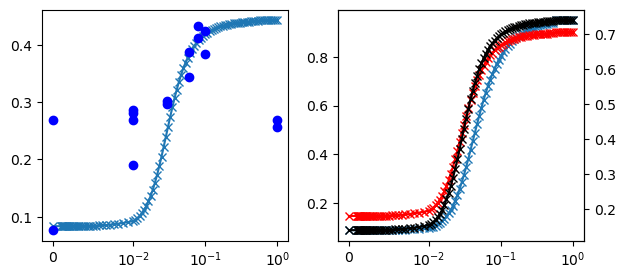

In [14]:
# Amp Circuit
K_Amp = 0.4
mu_max_amp = 0.6 / 60
n_Amp = 1.2

import matplotlib.pyplot as plt

# dAmpdt = ktrans_scaled_amp * mRNA_amp * S / (Ks + S) - (kdegP + mu_x_amp) * Amp
# dEnz_amp_optodt = ktrans_scaled_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp

ktrans_scaled = ktrans  * ((mu_max_amp + kdegP) / ktrans)
ss_Amp = - (1 / (2 * mu_max_amp)) * (kdegP - np.sqrt(4 * mRNA_arr_amp * mu_max_amp * ktrans_scaled + kdegP ** 2))
ktrans_scaled_PDC = ktrans  * ((mu_max_amp + kdegPPDC) / ktrans)
ss_Enz = - (1 / (2 * mu_max_amp)) * (kdegPPDC - np.sqrt(4 * (ss_Amp ** n_Amp / (K_Amp ** n_Amp + ss_Amp ** n_Amp)) * mu_max_amp * ktrans_scaled_PDC + kdegPPDC ** 2))

mu_arr_amp = ss_Enz * mu_max_amp * 60

# Real Data
mu_SGy128_4 = np.array([0.07654071, 0.26858448, 0.28688688, 0.19000113, 0.3834206 ,
       0.42503585, 0.25622547, 0.26932193, 0.30298274, 0.29615459,
       0.28158447, 0.26857221, 0.34449419, 0.38737338, 0.412247  ,
       0.43290314])
mu_SGy128_4_lags = np.array([ 0.        , 39.88279932, 19.98011315, 14.4137813 ,  0.        ,
        2.18260617,  0.        ,  1.21280087, 10.40812555,  7.77763666,
       21.22069601, 19.70771971,  1.68719277,  3.11811039,  2.52691981,
        2.30179095])
mu_SGy128_4_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_amp, '-x', label='mu')
ax.plot(mu_SGy128_4_lights, mu_SGy128_4, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, ss_Amp, '-x', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax2 = ax.twinx()
ax2.plot(u_arr, (ss_Amp / (K_Amp + ss_Amp)), '-rx', label='mu')
ax2.plot(u_arr, ss_Enz, '-kx', label='mu')


print(max(mu_arr_amp))
print(min(mu_arr_amp))

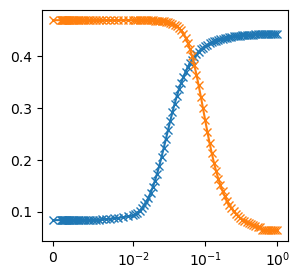

In [15]:
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_amp, '-x', label='mu_amp')
ax.plot(u_arr, mu_arr_invert, '-x', label='mu_invert')
ax.set_xscale('symlog', linthresh=0.01)

0
The solver successfully reached the end of the integration interval.
True


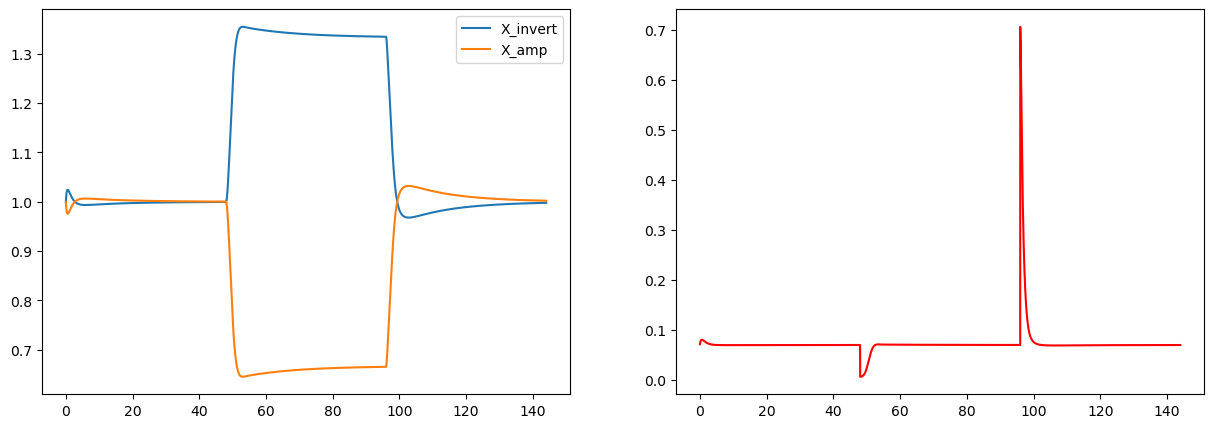

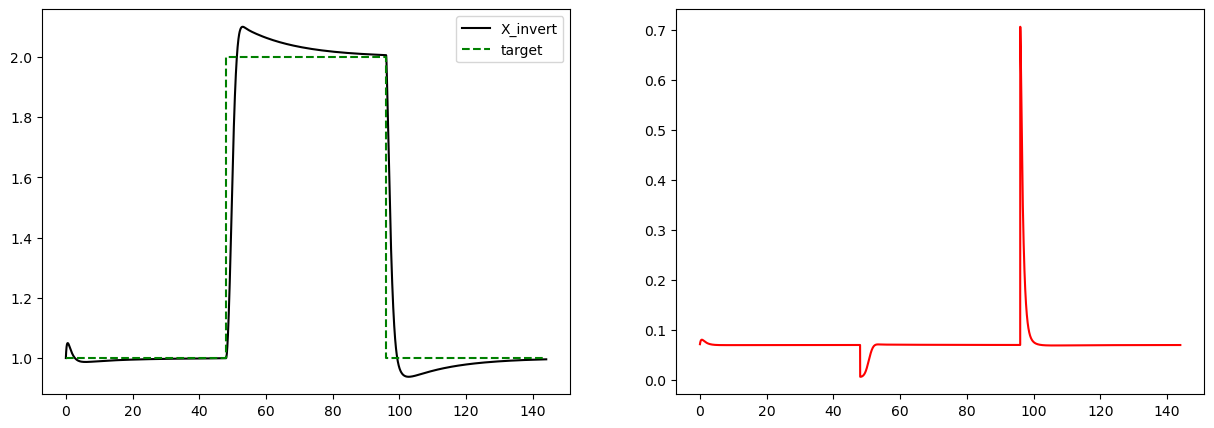

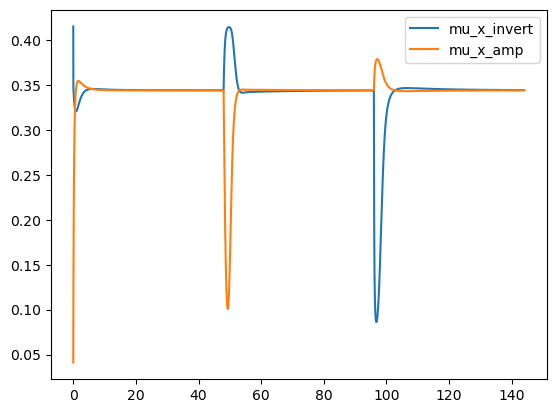

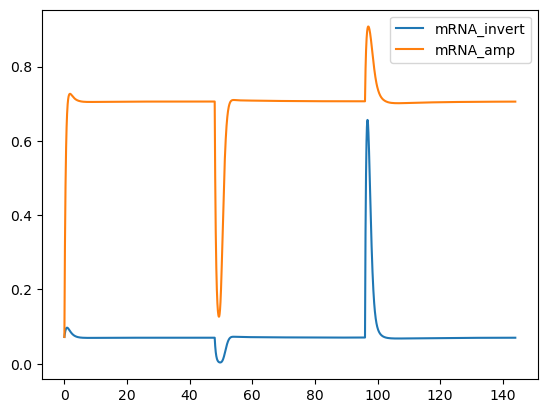

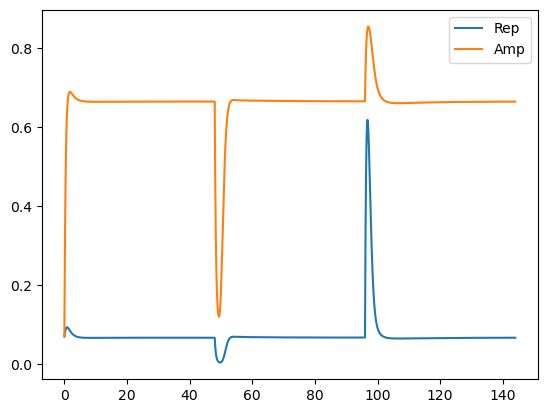

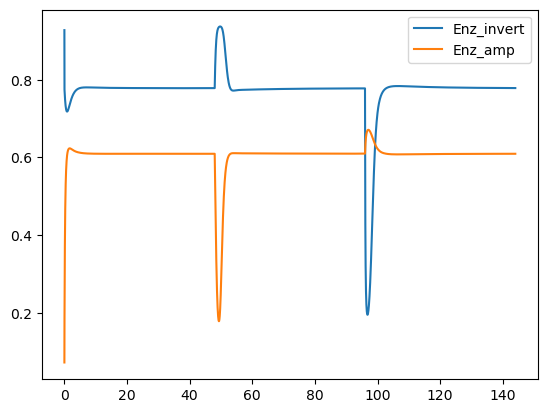

In [55]:
from scipy.interpolate import interp1d

# kdegR = 0.042116
# ktrans = 1.4514
# kdegP = 0.1
# K_Rep = 0.05
# K_Amp = 0.99
# n_Rep = 4
# n_Amp = 4
# kdegPPDC = 0

# mu_max_invert = 0.45 / 60
# mu_max_amp = 0.45 / 60

# # mu_max = mu_max_opto
# Ks = 1
# Y = 0.5


t_final = 144

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp


# def opto_growth(t,x,p, control_p, u0, mRNA_funs, ratio_sp=None, od_sp=None):
K_P = 1.0
K_I = 0.001
K_D = 10
control_p = K_P, K_I, K_D

tspan = [0, t_final*60]
u0 = np.log10(0.072)
u = 10 ** u0
mRNA_invert_fun = lambda  u: interp1d(u_arr, mRNA_arr_invert)(u)
mRNA_amp_fun = lambda  u: interp1d(u_arr, mRNA_arr_amp)(u)
mRNA_funs = mRNA_invert_fun, mRNA_amp_fun
od_sp = 2

def ratio_sp(t):
    t = np.array(t)
    output = np.zeros(t.size)
    output[t < 60*48] = 1
    output[t >= 60*48] = 2
    output[t >= 60*96] = 1
    return output

x_init = [u, u, u, u, 1-u, u, 20, 1, 1, 0]
x_init = np.array([mRNA_invert_fun(u), mRNA_amp_fun(u), mRNA_invert_fun(u), mRNA_amp_fun(u), 0.5, 0.5, 20, X10, X20,  0])

period = 100 / 60
Imax = 1

setpoint_amp = steady_mRNA_solve(u0, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
setpoint_invert = steady_mRNA_solve(u0, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

# print('my setpoint')
# print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

if u0 > 0:
    max_step = u0*period
else:
    max_step = period / 10

sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p, control_p, u0, mRNA_funs, ratio_sp, od_sp),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )
x_init = sol.y[:,-1]

print(sol.status)
print(sol.message)
print(sol.success)

mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x, I_x = sol.y

mRNA_invert = mRNA_invert_x
mRNA_amp = mRNA_amp_x
Rep = Rep_x
Amp = Amp_x
Enz_invert = Enz_invert_x
Enz_amp = Enz_amp_x
S = S_x
X_invert = X_invert_x
X_amp = X_amp_x
I = I_x
t_arr = sol.t

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

u_plot = u0 + K_P * (X_invert/X_amp - ratio_sp(t_arr)) + K_I * I
u_plot = np.clip(u_plot, -5, 0)
u_plot = 10 ** u_plot

fig = plt.figure(facecolor='white', figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(t_arr/60, X_invert, label='X_invert')
ax.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()
ax = fig.add_subplot(122)
ax.plot(t_arr/60, u_plot, 'r', label='u')

fig = plt.figure(facecolor='white', figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='X_invert')
ax.plot(t_arr/60, ratio_sp(t_arr), 'g--', label='target')
plt.legend()
ax = fig.add_subplot(122)
ax.plot(t_arr/60, u_plot, 'r', label='u')


plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
plt.legend()

0
The solver successfully reached the end of the integration interval.
True


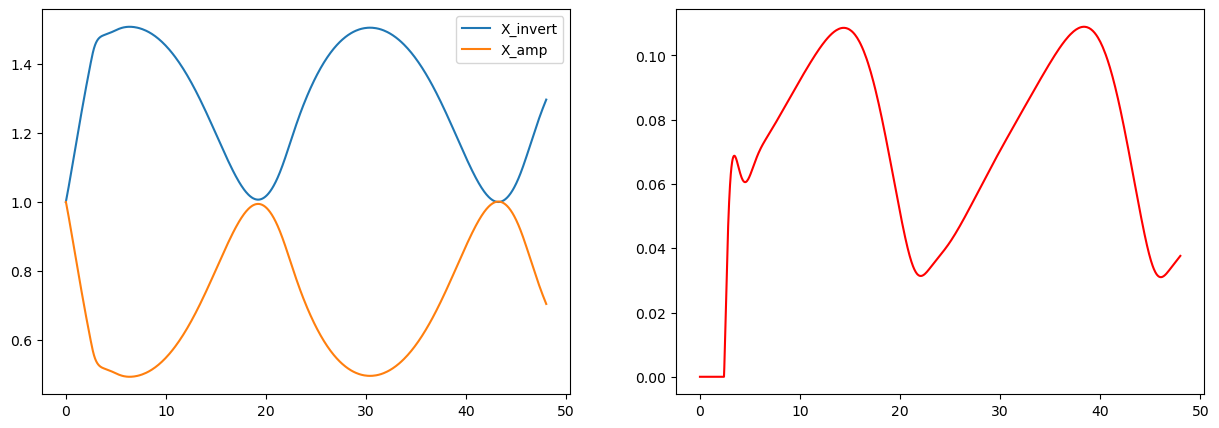

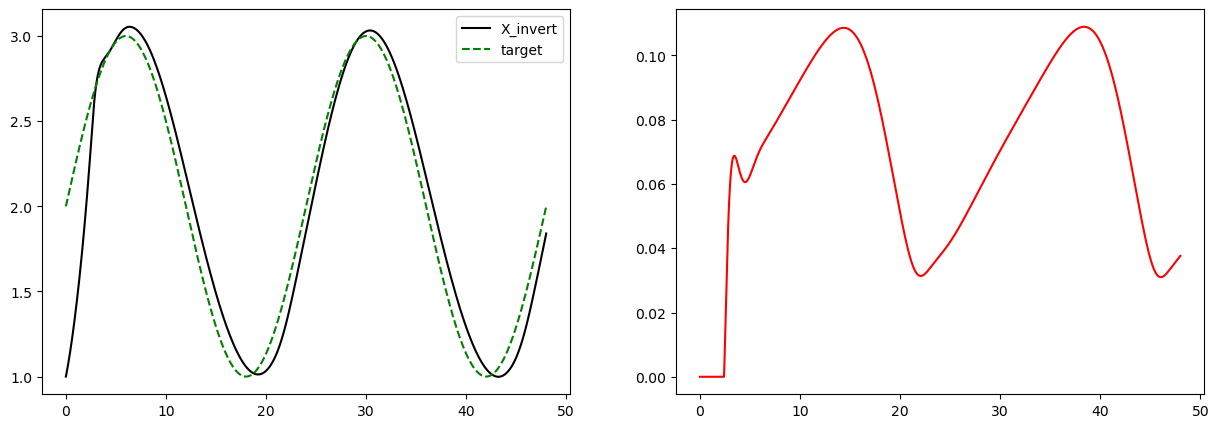

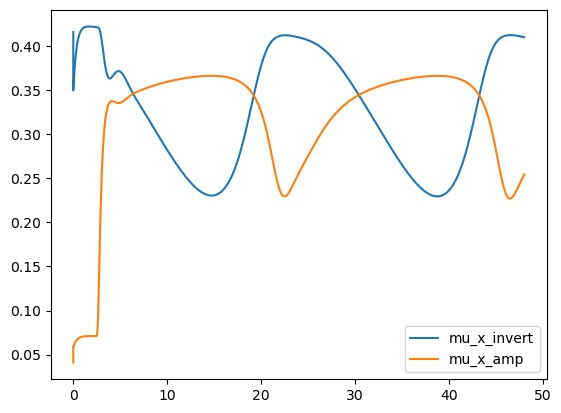

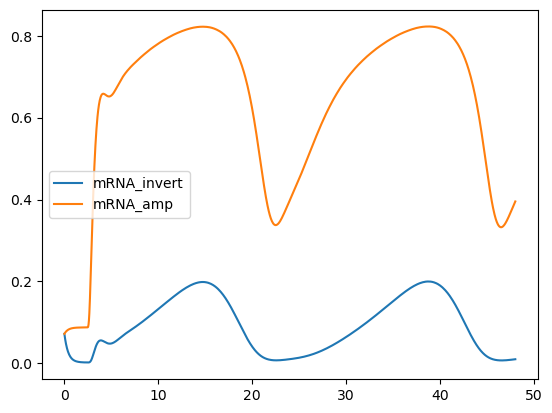

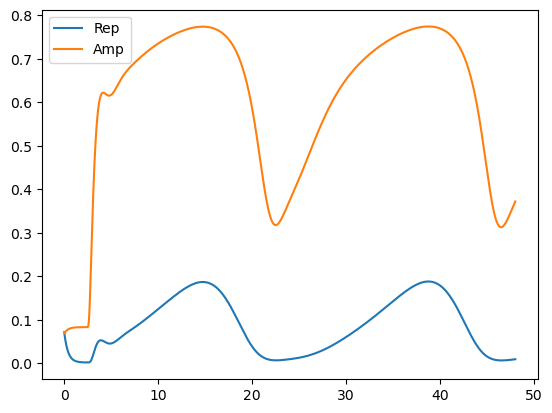

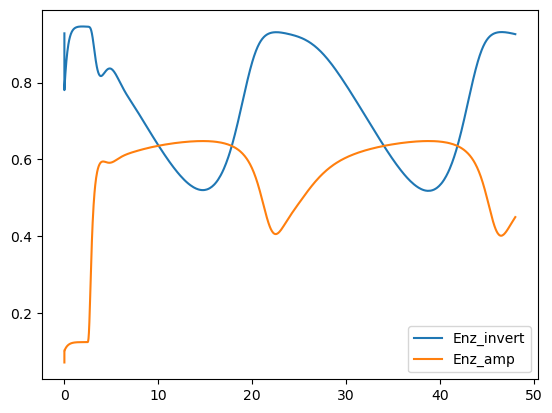

In [ ]:
from scipy.interpolate import interp1d

# kdegR = 0.042116
# ktrans = 1.4514
# kdegP = 0.1
# K_Rep = 0.05
# K_Amp = 0.99
# n_Rep = 4
# n_Amp = 4
# kdegPPDC = 0

# mu_max_invert = 0.45 / 60
# mu_max_amp = 0.45 / 60

# # mu_max = mu_max_opto
# Ks = 1
# Y = 0.5


t_final = 48

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp


# def opto_growth(t,x,p, control_p, u0, mRNA_funs, ratio_sp=None, od_sp=None):
K_P = 0.2
K_I = 0.0001
control_p = K_P, K_I

tspan = [0, t_final*60]
u0 = 0.072
mRNA_invert_fun = lambda  u: interp1d(u_arr, mRNA_arr_invert)(u)
mRNA_amp_fun = lambda  u: interp1d(u_arr, mRNA_arr_amp)(u)
mRNA_funs = mRNA_invert_fun, mRNA_amp_fun
od_sp = 2

def ratio_sp(t):
    t = np.array(t)
    output = np.sin(2*np.pi/(24*60)*t) + 2
    return output

x_init = [u0, u0, u0, u0, 1-u0, u0, 20, 1, 1, 0]

period = 100 / 60
Imax = 1

setpoint_amp = steady_mRNA_solve(u0, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
setpoint_invert = steady_mRNA_solve(u0, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

# print('my setpoint')
# print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

if u0 > 0:
    max_step = u0*period
else:
    max_step = period / 10

sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p, control_p, u0, mRNA_funs, ratio_sp, od_sp),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )
x_init = sol.y[:,-1]

print(sol.status)
print(sol.message)
print(sol.success)

mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x, I_x = sol.y

mRNA_invert = mRNA_invert_x
mRNA_amp = mRNA_amp_x
Rep = Rep_x
Amp = Amp_x
Enz_invert = Enz_invert_x
Enz_amp = Enz_amp_x
S = S_x
X_invert = X_invert_x
X_amp = X_amp_x
I = I_x
t_arr = sol.t

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

u_plot = u0 + K_P * (X_invert/X_amp - ratio_sp(t_arr)) + K_I * I
u_plot = np.clip(u_plot, 0, 1)

fig = plt.figure(facecolor='white', figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(t_arr/60, X_invert, label='X_invert')
ax.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()
ax = fig.add_subplot(122)
ax.plot(t_arr/60, u_plot, 'r', label='u')

fig = plt.figure(facecolor='white', figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='X_invert')
ax.plot(t_arr/60, ratio_sp(t_arr), 'g--', label='target')
plt.legend()
ax = fig.add_subplot(122)
ax.plot(t_arr/60, u_plot, 'r', label='u')


plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
plt.legend()